In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, transform
from PIL import Image
import os
import time
import copy
import warnings
warnings.filterwarnings('ignore')

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms, utils
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, StepLR
import sklearn
import sklearn.model_selection as skl
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sn

# Configurar matplotlib
%matplotlib inline

In [20]:
use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Dispositivo: {device}")
print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

# Configurar semilla para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Dispositivo: cuda:0
Torch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124


In [21]:
img_folder = '/kaggle/input/publicsargazods/images'
csv_file = '/kaggle/input/publicsargazods/labels/labels.csv'

# Hiperparámetros optimizados
epochs = 50
batch_size = 32  # Reducido para modelos más grandes
learning_rate = 0.0003  # Más conservador
model_name = 'efficientnet_b3'  # Modelo más moderno
pretrained = True
feature_extract = False
save_weights = True
early_stopping_patience = 10
mixup_alpha = 0.2
weight_decay = 0.01
label_smoothing = 0.1

# String para guardar pesos
wts_str = f'w_{model_name}_pret_{pretrained}_feat_{feature_extract}_lr_{learning_rate}_improved'
print(f"Archivo de pesos: {wts_str}")

Archivo de pesos: w_efficientnet_b3_pret_True_feat_False_lr_0.0003_improved


In [22]:
class2id = {'nada': 0, 'bajo': 1, 'moderado': 2, 'abundante': 3, 'excesivo': 4}
id2class = {0: 'nada', 1: 'bajo', 2: 'moderado', 3: 'abundante', 4: 'excesivo'}
num_classes = len(id2class)
col_labels = 'label'

In [23]:
def get_improved_transforms():
    """Transformaciones mejoradas con augmentación más robusta"""
    
    train_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224, scale=(0.6, 1.0), ratio=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(degrees=30),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.RandomGrayscale(p=0.1),
        # transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Comentado si no está disponible
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.33), ratio=(0.3, 3.3))
    ])
    
    val_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    return {'train': train_transforms, 'val': val_transforms}

In [24]:
class SargazoDatasetImproved(Dataset):
    """Dataset mejorado con mejor manejo de errores y carga de imágenes"""
    
    def __init__(self, dataframe, images_path, transform=None):
        self.sargazo_frame = dataframe.reset_index(drop=True)
        self.root_dir = images_path
        self.transform = transform
        self.class2id = class2id

    def pil_loader(self, path):
        """Carga robusta de imágenes"""
        try:
            with open(path, 'rb') as f:
                img = Image.open(f)
                return img.convert('RGB')
        except Exception as e:
            print(f"Error cargando imagen {path}: {e}")
            # Retornar imagen en negro como fallback
            return Image.new('RGB', (224, 224), (0, 0, 0))

    def __len__(self):
        return len(self.sargazo_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Obtener ruta de imagen y etiqueta
        image_path = os.path.join(self.root_dir, self.sargazo_frame.iloc[idx, 0])
        image = self.pil_loader(image_path)

        try:
            label = self.sargazo_frame.iloc[idx, 3]
        except:
            label = 'nada'  # Etiqueta por defecto

        if self.transform is not None:
            image = self.transform(image)

        return image, self.class2id[label]

In [25]:
def set_parameter_requires_grad(model, feature_extracting):
    """Congela parámetros para feature extraction"""
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [26]:
def initialize_modern_model(model_name, num_classes, feature_extract, use_pretrained=True):
    """Inicializa modelos modernos con mejor rendimiento"""
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnet50":
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "efficientnet_b0":
        model_ft = models.efficientnet_b0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        # Añadir dropout adicional
        model_ft.classifier = nn.Sequential(
            nn.Dropout(p=0.3, inplace=True),
            nn.Linear(num_ftrs, num_classes)
        )
        input_size = 224

    elif model_name == "efficientnet_b3":
        model_ft = models.efficientnet_b3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        # Añadir dropout adicional
        model_ft.classifier = nn.Sequential(
            nn.Dropout(p=0.4, inplace=True),
            nn.Linear(num_ftrs, num_classes)
        )
        input_size = 300

    elif model_name == "resnext50":
        model_ft = models.resnext50_32x4d(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(num_ftrs, num_classes)
        )
        input_size = 224

    elif model_name == "vgg":
        model_ft = models.vgg16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Nombre de modelo inválido, usando ResNet18...")
        return initialize_modern_model("resnet", num_classes, feature_extract, use_pretrained)

    return model_ft, input_size

In [27]:
def mixup_data(x, y, alpha=1.0, device='cuda'):
    """Implementa Mixup augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Criterio de pérdida para Mixup"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [28]:
def train_model_improved(model, dataloaders, criterion, optimizer, scheduler=None, 
                        num_epochs=25, early_stopping_patience=7, mixup_alpha=0.2):
    """
    Función de entrenamiento mejorada con:
    - Early stopping
    - Mixup augmentation
    - Gradient clipping
    - Mejores métricas de seguimiento
    """
    since = time.time()
    
    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []
    val_f1_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_f1 = 0.0
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0  # Changed to float to handle mixup accuracy
            all_preds = []
            all_labels = []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train' and mixup_alpha > 0 and np.random.random() > 0.5:
                        # Aplicar Mixup solo en el 50% de los batches de entrenamiento
                        inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, mixup_alpha, device)
                        outputs = model(inputs)
                        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
                        
                        # Para mixup, calcular precisión aproximada
                        _, preds = torch.max(outputs, 1)
                        running_corrects += (lam * preds.eq(targets_a).float().sum() + 
                                           (1 - lam) * preds.eq(targets_b).float().sum()).item()
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)
                        running_corrects += torch.sum(preds == labels.data).item()
                        
                        if phase == 'val':
                            all_preds.extend(preds.cpu().numpy())
                            all_labels.extend(labels.cpu().numpy())

                    if phase == 'train':
                        loss.backward()
                        # Gradient clipping para estabilidad
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)

            # Calcular F1-score para validación
            if phase == 'val' and len(all_preds) > 0:
                epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
                val_f1_history.append(epoch_f1)
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')
            else:
                epoch_f1 = 0
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Guardar métricas
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
                
                # Early stopping y mejor modelo basado en F1-score
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    patience_counter = 0
                    torch.save(model.state_dict(), wts_str + '_best.pt')
                    print(f"Nuevo mejor modelo guardado: F1={epoch_f1:.4f}")
                else:
                    patience_counter += 1
                    
                # Scheduler step
                if scheduler:
                    if isinstance(scheduler, ReduceLROnPlateau):
                        scheduler.step(epoch_loss)
                    else:
                        scheduler.step()
                        
            elif phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()
        
        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f'Early stopping activado después de {epoch + 1} épocas')
            break

    time_elapsed = time.time() - since
    print(f'Entrenamiento completado en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Mejor val Acc: {best_acc:.4f}, Mejor F1: {best_f1:.4f}')

    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, val_loss_history, train_loss_history, val_f1_history


In [29]:
def evaluate_model_detailed(model, dataloader, class_names):
    """Evaluación detallada con múltiples métricas"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Métricas detalladas
    print("=== REPORTE DETALLADO ===")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # F1-scores individuales
    f1_scores = f1_score(all_labels, all_preds, average=None)
    for i, class_name in enumerate(class_names):
        print(f"F1-score {class_name}: {f1_scores[i]:.3f}")
    
    # F1-scores promedio
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    print(f"F1-score macro: {f1_macro:.3f}")
    print(f"F1-score weighted: {f1_weighted:.3f}")
    
    return all_preds, all_labels, all_probs, f1_weighted

In [30]:
full_dataset = pd.read_csv(csv_file)
print(f"Dataset cargado: {len(full_dataset)} imágenes")
print(f"Distribución de clases:")
print(full_dataset[col_labels].value_counts().sort_index())

# División estratificada del dataset
random_state = 42
train_df, valid_df = skl.train_test_split(
    full_dataset, 
    test_size=0.2, 
    stratify=full_dataset[col_labels], 
    random_state=random_state
)

print(f"\nConjunto de entrenamiento: {len(train_df)} imágenes")
print(f"Conjunto de validación: {len(valid_df)} imágenes")

# Mostrar distribución de clases
train_class_counts = train_df[col_labels].value_counts().sort_index()
valid_class_counts = valid_df[col_labels].value_counts().sort_index()

print("\nDistribución en entrenamiento:")
for class_name in ['nada', 'bajo', 'moderado', 'abundante', 'excesivo']:
    count = train_class_counts.get(class_name, 0)
    print(f"  {class_name}: {count}")

print("\nDistribución en validación:")
for class_name in ['nada', 'bajo', 'moderado', 'abundante', 'excesivo']:
    count = valid_class_counts.get(class_name, 0)
    print(f"  {class_name}: {count}")

Dataset cargado: 2472 imágenes
Distribución de clases:
label
abundante     148
bajo          711
excesivo      206
moderado      227
nada         1180
Name: count, dtype: int64

Conjunto de entrenamiento: 1977 imágenes
Conjunto de validación: 495 imágenes

Distribución en entrenamiento:
  nada: 944
  bajo: 569
  moderado: 181
  abundante: 118
  excesivo: 165

Distribución en validación:
  nada: 236
  bajo: 142
  moderado: 46
  abundante: 30
  excesivo: 41


In [31]:
classes = np.array([0, 1, 2, 3, 4])
train_labels = [class2id[label] for label in train_df[col_labels]]
class_weights = compute_class_weight('balanced', classes=classes, y=train_labels)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print(f"\nClass weights calculados:")
for i, class_name in enumerate(['nada', 'bajo', 'moderado', 'abundante', 'excesivo']):
    print(f"  {class_name}: {class_weights[i]:.3f}")



Class weights calculados:
  nada: 0.419
  bajo: 0.695
  moderado: 2.185
  abundante: 3.351
  excesivo: 2.396


In [32]:
data_transforms = get_improved_transforms()

# Crear datasets
train_dataset = SargazoDatasetImproved(train_df, img_folder, data_transforms['train'])
val_dataset = SargazoDatasetImproved(valid_df, img_folder, data_transforms['val'])

# Crear dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
}

print(f"\nDataloaders creados:")
print(f"  Train batches: {len(dataloaders['train'])}")
print(f"  Val batches: {len(dataloaders['val'])}")


Dataloaders creados:
  Train batches: 62
  Val batches: 16



Mostrando ejemplos del dataset:


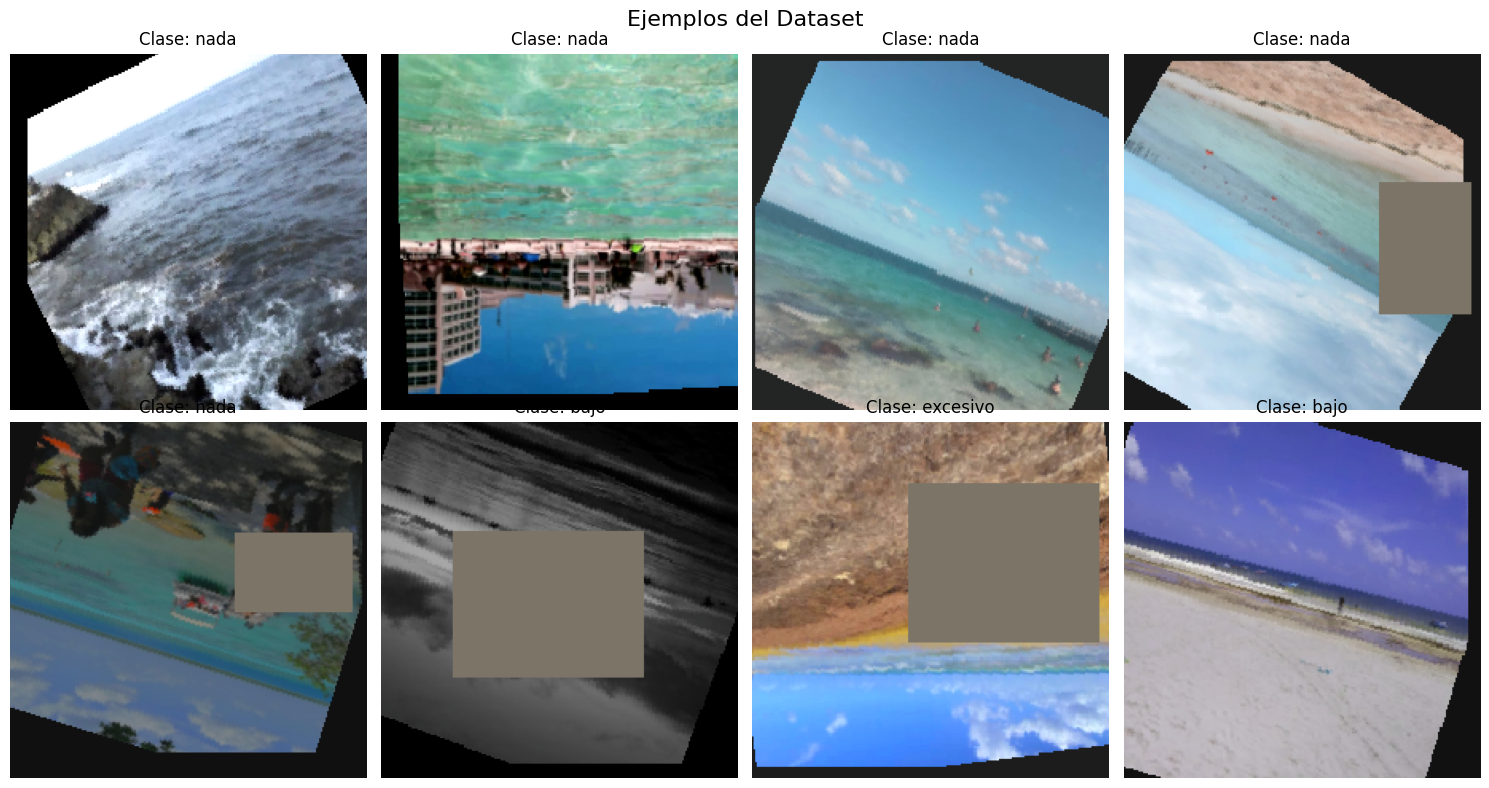

In [33]:
def show_sample_images(dataset, num_samples=8):
    """Muestra imágenes de ejemplo del dataset"""
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    fig.suptitle('Ejemplos del Dataset', fontsize=16)
    
    for i in range(num_samples):
        if i < len(dataset):
            image, label = dataset[i]
            
            # Convertir tensor a imagen
            if isinstance(image, torch.Tensor):
                # Desnormalizar
                mean = torch.tensor([0.485, 0.456, 0.406])
                std = torch.tensor([0.229, 0.224, 0.225])
                image = image * std[:, None, None] + mean[:, None, None]
                image = torch.clamp(image, 0, 1)
                image = image.permute(1, 2, 0)
            
            row = i // 4
            col = i % 4
            axes[row, col].imshow(image)
            axes[row, col].set_title(f'Clase: {id2class[label]}')
            axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Mostrar ejemplos
print("\nMostrando ejemplos del dataset:")
show_sample_images(train_dataset)


In [34]:
print(f"\nInicializando modelo: {model_name}")
model_ft, input_size = initialize_modern_model(model_name, num_classes, feature_extract, pretrained)
model_ft = model_ft.to(device)

print(f"Tamaño de entrada: {input_size}")
print(f"Número de parámetros: {sum(p.numel() for p in model_ft.parameters()):,}")
print(f"Parámetros entrenables: {sum(p.numel() for p in model_ft.parameters() if p.requires_grad):,}")


Inicializando modelo: efficientnet_b3
Tamaño de entrada: 300
Número de parámetros: 10,703,917
Parámetros entrenables: 10,703,917


In [35]:
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad:
            params_to_update.append(param)
            print(f"  Entrenando: {name}")
else:
    params_to_update = model_ft.parameters()
    print("Entrenando todos los parámetros")

# Optimizador AdamW con mejores parámetros
optimizer = optim.AdamW(
    params_to_update,
    lr=learning_rate,
    weight_decay=weight_decay,
    betas=(0.9, 0.999)
)

# Scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=epochs//5, eta_min=1e-6)

# Criterio con class weights y label smoothing
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=label_smoothing)

print(f"\nConfiguración de entrenamiento:")
print(f"  Optimizador: AdamW")
print(f"  Learning rate: {learning_rate}")
print(f"  Weight decay: {weight_decay}")
print(f"  Scheduler: CosineAnnealingLR")
print(f"  Label smoothing: {label_smoothing}")
print(f"  Mixup alpha: {mixup_alpha}")

Entrenando todos los parámetros

Configuración de entrenamiento:
  Optimizador: AdamW
  Learning rate: 0.0003
  Weight decay: 0.01
  Scheduler: CosineAnnealingLR
  Label smoothing: 0.1
  Mixup alpha: 0.2


In [36]:
print(f"\n{'='*50}")
print("INICIANDO ENTRENAMIENTO")
print(f"{'='*50}")

# Entrenar modelo
run_training = True
if run_training:
    model_ft, val_acc_hist, train_acc_hist, val_loss_hist, train_loss_hist, val_f1_hist = train_model_improved(
        model_ft, 
        dataloaders, 
        criterion, 
        optimizer, 
        scheduler,
        num_epochs=epochs, 
        early_stopping_patience=early_stopping_patience, 
        mixup_alpha=mixup_alpha
    )

    # Guardar modelo final
    if save_weights:
        torch.save(model_ft.state_dict(), wts_str + '_final.pt')
        print(f"Modelo final guardado: {wts_str}_final.pt")



INICIANDO ENTRENAMIENTO
Epoch 0/49
----------
train Loss: 1.7050 Acc: 0.2496
val Loss: 1.5668 Acc: 0.4727 F1: 0.4686
Nuevo mejor modelo guardado: F1=0.4686

Epoch 1/49
----------
train Loss: 1.5621 Acc: 0.4692
val Loss: 1.4775 Acc: 0.5778 F1: 0.5781
Nuevo mejor modelo guardado: F1=0.5781

Epoch 2/49
----------
train Loss: 1.5137 Acc: 0.5004
val Loss: 1.4515 Acc: 0.5859 F1: 0.5779

Epoch 3/49
----------
train Loss: 1.4412 Acc: 0.5489
val Loss: 1.4700 Acc: 0.5939 F1: 0.5972
Nuevo mejor modelo guardado: F1=0.5972

Epoch 4/49
----------
train Loss: 1.3776 Acc: 0.5854
val Loss: 1.4532 Acc: 0.6020 F1: 0.6011
Nuevo mejor modelo guardado: F1=0.6011

Epoch 5/49
----------
train Loss: 1.3248 Acc: 0.5970
val Loss: 1.4111 Acc: 0.6182 F1: 0.6262
Nuevo mejor modelo guardado: F1=0.6262

Epoch 6/49
----------
train Loss: 1.3311 Acc: 0.6056
val Loss: 1.4086 Acc: 0.6081 F1: 0.6146

Epoch 7/49
----------
train Loss: 1.2789 Acc: 0.6369
val Loss: 1.4306 Acc: 0.6343 F1: 0.6388
Nuevo mejor modelo guardado: 

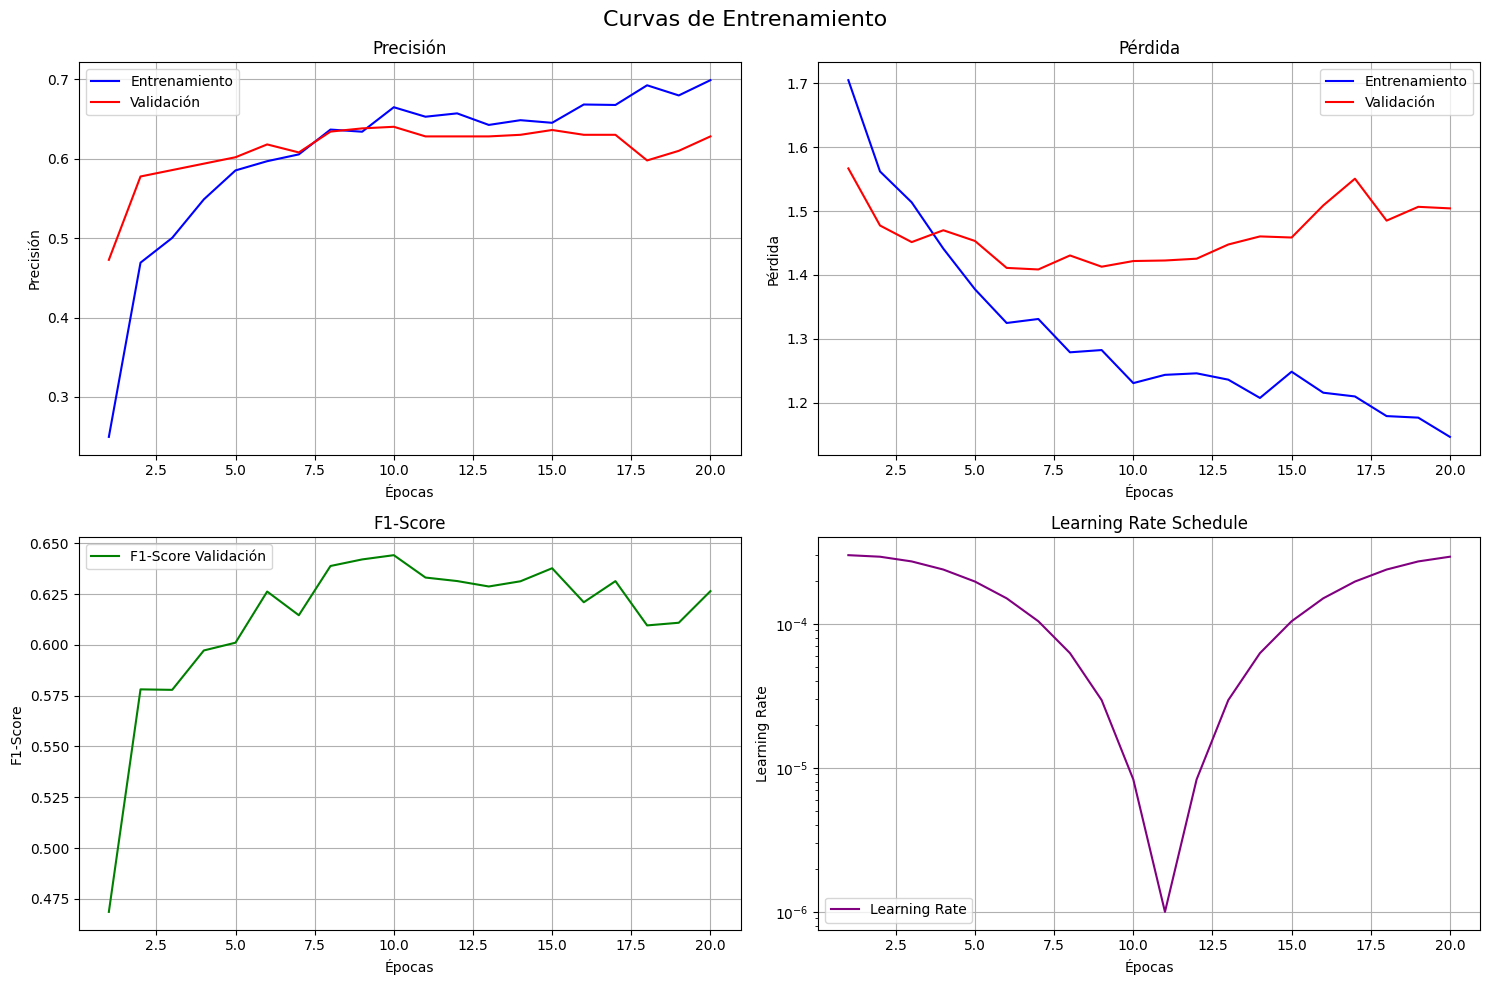

In [37]:
def plot_training_curves(train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist, val_f1_hist):
    """Grafica las curvas de entrenamiento"""
    
    epochs_range = range(1, len(train_acc_hist) + 1)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Curvas de Entrenamiento', fontsize=16)
    
    # Accuracy
    ax1.plot(epochs_range, [acc.cpu().numpy() if hasattr(acc, 'cpu') else acc for acc in train_acc_hist], 'b-', label='Entrenamiento')
    ax1.plot(epochs_range, [acc.cpu().numpy() if hasattr(acc, 'cpu') else acc for acc in val_acc_hist], 'r-', label='Validación')
    ax1.set_title('Precisión')
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Precisión')
    ax1.legend()
    ax1.grid(True)
    
    # Loss
    ax2.plot(epochs_range, train_loss_hist, 'b-', label='Entrenamiento')
    ax2.plot(epochs_range, val_loss_hist, 'r-', label='Validación')
    ax2.set_title('Pérdida')
    ax2.set_xlabel('Épocas')
    ax2.set_ylabel('Pérdida')
    ax2.legend()
    ax2.grid(True)
    
    # F1-Score
    if val_f1_hist:
        ax3.plot(range(1, len(val_f1_hist) + 1), val_f1_hist, 'g-', label='F1-Score Validación')
        ax3.set_title('F1-Score')
        ax3.set_xlabel('Épocas')
        ax3.set_ylabel('F1-Score')
        ax3.legend()
        ax3.grid(True)
    
    # Learning Rate
    if hasattr(scheduler, 'get_last_lr'):
        lrs = []
        temp_scheduler = CosineAnnealingLR(optimizer, T_max=epochs//5, eta_min=1e-6)
        for _ in range(len(train_acc_hist)):
            lrs.append(temp_scheduler.get_last_lr()[0])
            temp_scheduler.step()
        
        ax4.plot(epochs_range, lrs, 'purple', label='Learning Rate')
        ax4.set_title('Learning Rate Schedule')
        ax4.set_xlabel('Épocas')
        ax4.set_ylabel('Learning Rate')
        ax4.set_yscale('log')
        ax4.legend()
        ax4.grid(True)
    
    plt.tight_layout()
    plt.savefig(wts_str + '_training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

if run_training:
    plot_training_curves(train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist, val_f1_hist)


EVALUACIÓN FINAL
=== REPORTE DETALLADO ===
              precision    recall  f1-score   support

        nada       0.81      0.73      0.77       236
        bajo       0.56      0.58      0.57       142
    moderado       0.44      0.33      0.38        46
   abundante       0.30      0.43      0.35        30
    excesivo       0.60      0.80      0.69        41

    accuracy                           0.64       495
   macro avg       0.54      0.58      0.55       495
weighted avg       0.66      0.64      0.64       495

F1-score nada: 0.771
F1-score bajo: 0.570
F1-score moderado: 0.375
F1-score abundante: 0.351
F1-score excesivo: 0.688
F1-score macro: 0.551
F1-score weighted: 0.644

Matriz de Confusión:
           nada  bajo  moderado  abundante  excesivo
nada        173    47         4          9         3
bajo         36    83        10          8         5
moderado      3    11        15          9         8
abundante     1     7         3         13         6
excesivo      0

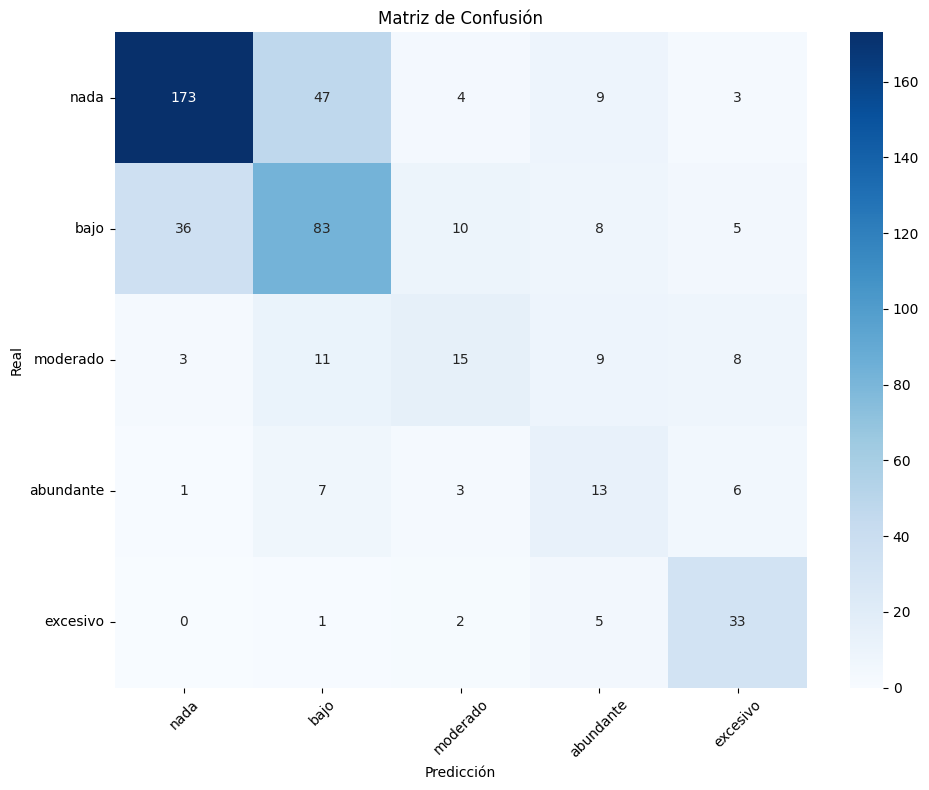

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [38]:
print(f"\n{'='*50}")
print("EVALUACIÓN FINAL")
print(f"{'='*50}")

class_names = ['nada', 'bajo', 'moderado', 'abundante', 'excesivo']
pred_labels, actual_labels, probs, final_f1 = evaluate_model_detailed(model_ft, dataloaders['val'], class_names)

# Matriz de confusión
cm = confusion_matrix(actual_labels, pred_labels)
df_confusion = pd.DataFrame(cm, index=class_names, columns=class_names)

print(f"\nMatriz de Confusión:")
print(df_confusion)

# Visualizar matriz de confusión
plt.figure(figsize=(10, 8))
sn.heatmap(df_confusion, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(wts_str + '_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Matriz de confusión normalizada
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_confusion_norm = pd.DataFrame(cm_normalized, index=class_names, columns=class_names)

plt.figure(figsize=(10, 8))